In [12]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style='darkgrid', palette='muted')
plt.rcParams['figure.dpi'] = 120

DATA_DIR = Path('../data/raw')

In [13]:
reviews = pd.read_json(DATA_DIR / 'reviews_electronics.jsonl', lines=True)
meta    = pd.read_json(DATA_DIR / 'meta_electronics.jsonl', lines=True)

print(f'Reviews : {len(reviews):,} rows × {reviews.shape[1]} cols')
print(f'Metadata: {len(meta):,} rows × {meta.shape[1]} cols')

Reviews : 200,000 rows × 10 cols
Metadata: 8,454 rows × 15 cols


In [14]:
reviews.head(3)

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,3,camera,Over all its about the same as the camera I wa...,[],B004MB9UMM,B005HGILN0,AHU63DJFTJKHHGHUYHVN2SFI2MSQ,2013-06-07 07:28:54.000,0,True
1,5,Fugifilm Instax 9 Mini accessories pack,Lots....and I mean lots of great and fun thing...,[],B073TSDN98,B07BTMNCVB,AGKB3STBUXZM7NXJT6RRC7FDMJLA,2017-12-07 16:08:31.837,2,True
2,5,Great plugs for my MP3,"Long cord, good sound. Fits my Sandisk clip sp...",[],B01N0TOCQT,B01N0TOCQT,AHHG4N3KPSPVMDKH3TDPNKNKPRDQ,2018-01-11 23:14:24.270,0,True


In [15]:
meta.head(3)

,main_category,title,average_rating,rating_number,features,description,price,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Amazon Home,"Aproca Hard Storage Travel Case, for AKASO EK7...",4.6,489,[Eco-friendly Material: Made of High-density E...,[],14.99,{'title': ['LTGEM EVA Hard Case for AKASO EK70...,Aproca,"[Electronics, Camera & Photo, Bags & Cases, Ca...","{""Package Dimensions"": ""9.1 x 5.8 x 3.6 inches...",B07ZZ595TG,NaN,None,None
1,All Electronics,Verbatim 4.7GB Up to 16X Datalifeplus White In...,4.6,1104,[50 high-grade non-rewritable DVD-R inkjet pri...,[Combining an exceptional inkjet hub-printable...,26.94,"{'title': ['Verbatim DVD-R Life Series ', 'The...",Verbatim,"[Electronics, Computers & Accessories, Compute...","{""Product Dimensions"": ""5.44 x 4.19 x 4.94 inc...",B08X2DCF2B,NaN,None,None
2,All Electronics,"Anker Power Strip Surge Protector, 12 Outlets ...",4.8,15740,[Power for All: 12 AC outlets and 3 USB ports ...,[],None,{'title': ['Anker Power Strip Surge Protector ...,Anker,"[Electronics, Accessories & Supplies, Power St...","{""Product Dimensions"": ""12.9 x 4.73 x 1.4 inch...",B08Y8FSTMT,NaN,None,None


## 1. Rating distribution

The label for our recommendation task is binarised from star rating: **liked (≥4★)** vs **not liked (<4★)**. Before binarising, let's see the raw distribution.

/var/folders/kc/7l_t_z7s4wz3dc4r20zg8y140000gn/T/ipykernel_12832/2925552969.py:22: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  plt.tight_layout()
/Users/itamrakar/miniconda3/envs/bayesian-recommender/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9733 (\N{BLACK STAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


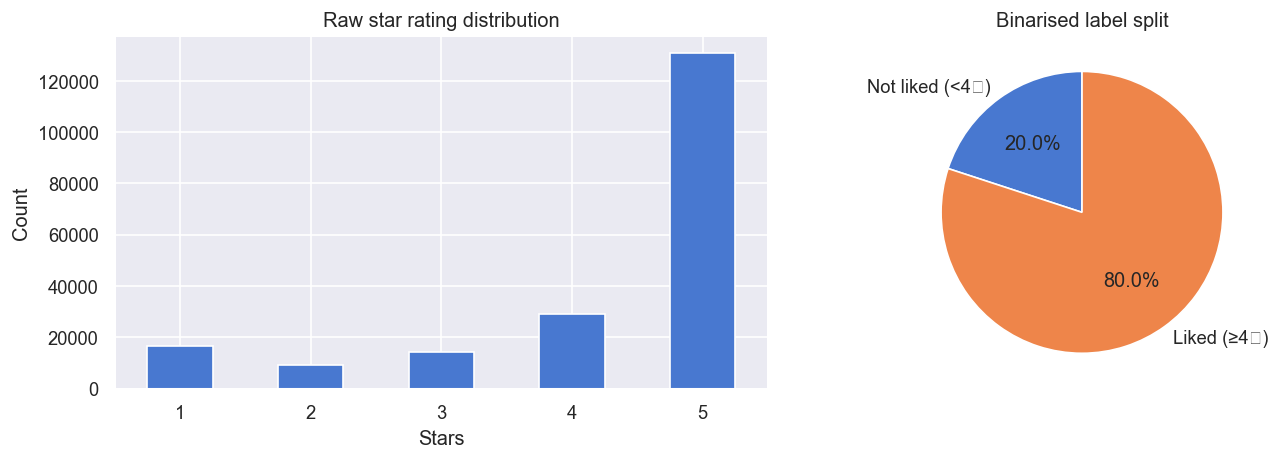

Class imbalance ratio: 4.01  (liked : not-liked)


In [16]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

reviews['rating'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color=sns.color_palette('muted')[0], edgecolor='white'
)
axes[0].set_title('Raw star rating distribution')
axes[0].set_xlabel('Stars')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

reviews['liked'] = (reviews['rating'] >= 4).astype(int)
label_counts = reviews['liked'].value_counts().sort_index()  # 0=not-liked, 1=liked
axes[1].pie(
    label_counts,
    labels=['Not liked (<4★)', 'Liked (≥4★)'],
    autopct='%1.1f%%',
    colors=sns.color_palette('muted')[:2],
    startangle=90
)
axes[1].set_title('Binarised label split')

plt.tight_layout()
plt.show()

print(f"Class imbalance ratio: {label_counts[1] / label_counts[0]:.2f}  (liked : not-liked)")

## 2. Review text length

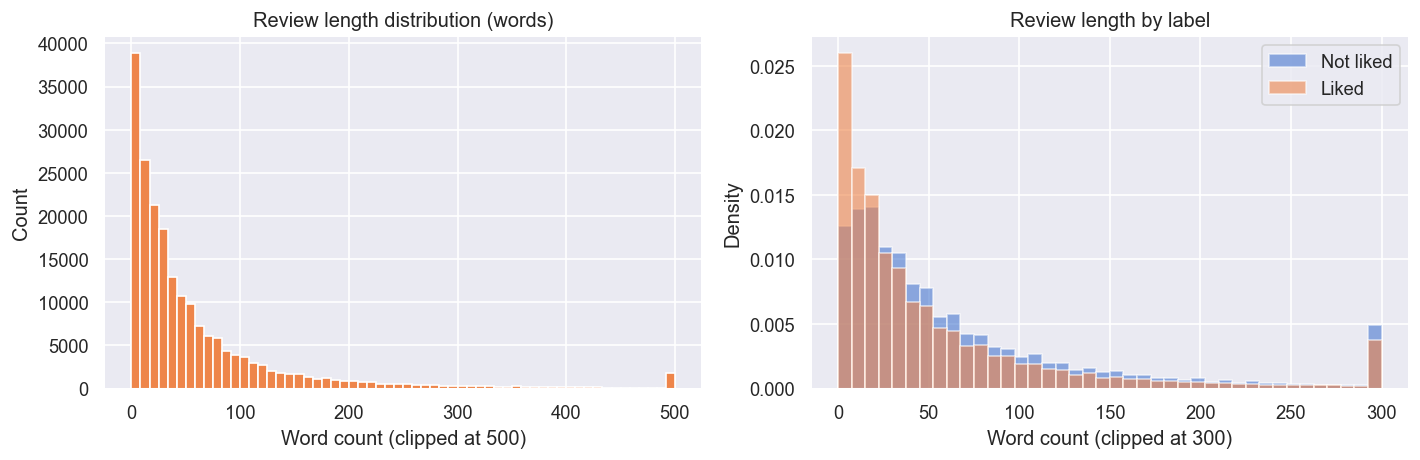

count    200000.000000
mean         61.733445
std          99.537919
min           0.000000
25%          12.000000
50%          31.000000
75%          72.000000
max        5313.000000


In [17]:
reviews['text'] = reviews['text'].fillna('')
reviews['review_len'] = reviews['text'].str.split().str.len()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Full distribution (clipped for readability)
axes[0].hist(reviews['review_len'].clip(upper=500), bins=60,
             color=sns.color_palette('muted')[1], edgecolor='white')
axes[0].set_title('Review length distribution (words)')
axes[0].set_xlabel('Word count (clipped at 500)')
axes[0].set_ylabel('Count')

# By label
for label, grp in reviews.groupby('liked'):
    axes[1].hist(grp['review_len'].clip(upper=300), bins=40, alpha=0.6,
                 label='Liked' if label else 'Not liked', density=True)
axes[1].set_title('Review length by label')
axes[1].set_xlabel('Word count (clipped at 300)')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

print(reviews['review_len'].describe().to_string())

## 3. Price distribution

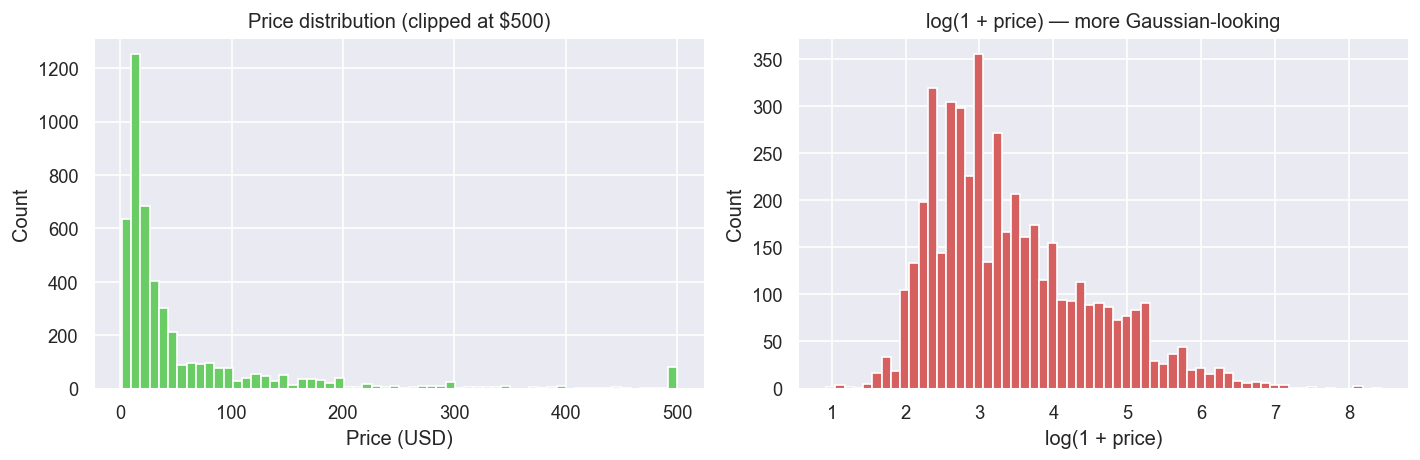

Missing price: 44.2%
count    4716.000000
mean       65.199065
std       161.881954
min         1.520000
25%        12.990000
50%        23.990000
75%        54.990000
max      4599.000000


In [18]:
meta['price'] = pd.to_numeric(meta['price'], errors='coerce')
price_valid = meta['price'].dropna()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(price_valid.clip(upper=500), bins=60,
             color=sns.color_palette('muted')[2], edgecolor='white')
axes[0].set_title('Price distribution (clipped at $500)')
axes[0].set_xlabel('Price (USD)')
axes[0].set_ylabel('Count')

axes[1].hist(np.log1p(price_valid), bins=60,
             color=sns.color_palette('muted')[3], edgecolor='white')
axes[1].set_title('log(1 + price) — more Gaussian-looking')
axes[1].set_xlabel('log(1 + price)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

missing_pct = meta['price'].isna().mean() * 100
print(f"Missing price: {missing_pct:.1f}%")
print(price_valid.describe().to_string())

## 4. Category breakdown

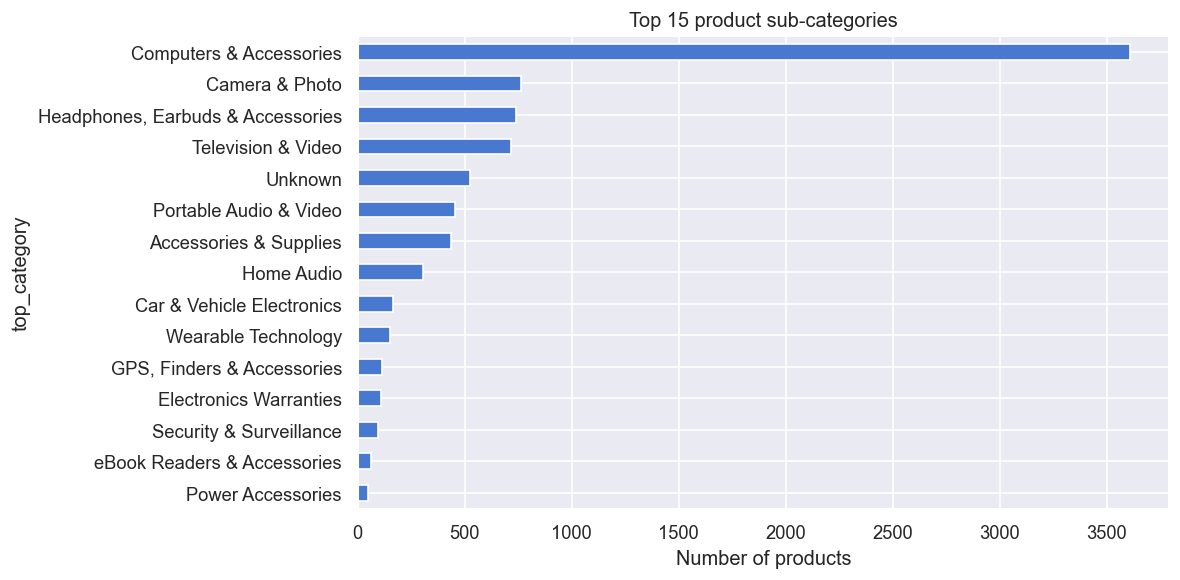

In [20]:
# Extract the second-level category (index 1 is more specific than 'Electronics')
meta['top_category'] = meta['categories'].apply(
    lambda c: c[1] if isinstance(c, list) and len(c) > 1 else 'Unknown'
)

top_cats = meta['top_category'].value_counts().head(15)

fig, ax = plt.subplots(figsize=(10, 5))
top_cats.plot(kind='barh', ax=ax, color=sns.color_palette('muted')[0], edgecolor='white')
ax.set_title('Top 15 product sub-categories')
ax.set_xlabel('Number of products')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

## 5. User activity — cold-start vs established users

This is critical for the Bayesian analysis: MAP smoothing matters most for users with very few reviews. Let's see how many cold-start users we have.

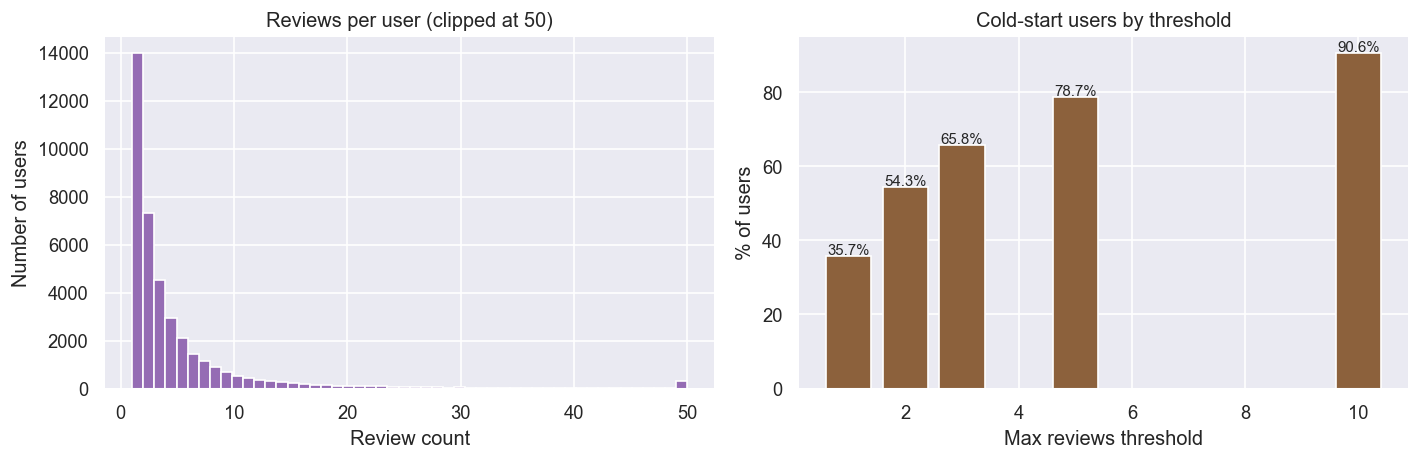

Total unique users  : 39,198
Median reviews/user : 2
Mean reviews/user   : 5.10


In [21]:
user_counts = reviews['user_id'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(user_counts.clip(upper=50), bins=50,
             color=sns.color_palette('muted')[4], edgecolor='white')
axes[0].set_title('Reviews per user (clipped at 50)')
axes[0].set_xlabel('Review count')
axes[0].set_ylabel('Number of users')

thresholds = [1, 2, 3, 5, 10]
cold_start_pcts = [(user_counts <= t).mean() * 100 for t in thresholds]
axes[1].bar(thresholds, cold_start_pcts, color=sns.color_palette('muted')[5], edgecolor='white')
axes[1].set_title('Cold-start users by threshold')
axes[1].set_xlabel('Max reviews threshold')
axes[1].set_ylabel('% of users')
for x, y in zip(thresholds, cold_start_pcts):
    axes[1].text(x, y + 0.5, f'{y:.1f}%', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

print(f"Total unique users  : {len(user_counts):,}")
print(f"Median reviews/user : {user_counts.median():.0f}")
print(f"Mean reviews/user   : {user_counts.mean():.2f}")

## 6. Verified purchases and helpful votes

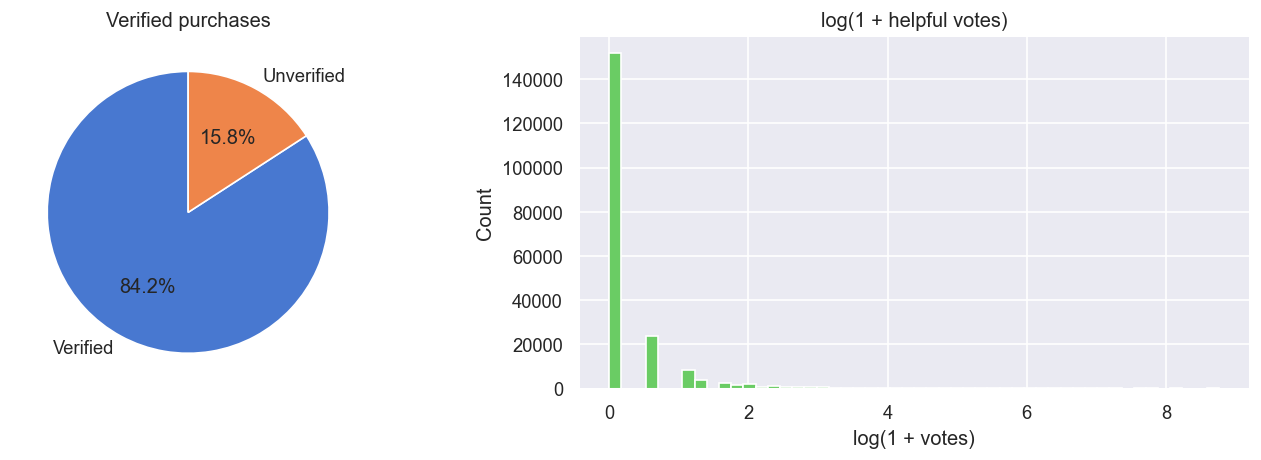

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Verified purchase split
vp = reviews['verified_purchase'].value_counts()
axes[0].pie(vp, labels=['Verified', 'Unverified'], autopct='%1.1f%%',
            colors=sns.color_palette('muted')[:2], startangle=90)
axes[0].set_title('Verified purchases')

# Helpful votes (log scale)
helpful = reviews['helpful_vote'].clip(lower=0)
axes[1].hist(np.log1p(helpful), bins=50,
             color=sns.color_palette('muted')[2], edgecolor='white')
axes[1].set_title('log(1 + helpful votes)')
axes[1].set_xlabel('log(1 + votes)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

## 7. Missing data summary

In [23]:
def missing_summary(df, name):
    m = df.isna().mean().mul(100).sort_values(ascending=False)
    m = m[m > 0]
    print(f"\n{name} — missing values:")
    print(m.to_string(float_format=lambda x: f'{x:.1f}%'))

missing_summary(reviews, 'Reviews')
missing_summary(meta, 'Metadata')


Reviews — missing values:
Series([], )

Metadata — missing values:
bought_together   100.0%
subtitle           99.9%
author             99.9%
price              44.2%
main_category       1.7%
store               0.2%
